# Cryptocurrency Analysis after Presidential Election - Buy and Hold

In this project, I am going to analyze Bitcoin and Ethereum or Litecoin  as these 2 were the most profitable coins after the presidential elections in USA and try to invest using buy and hold strategy. 
I'll be going through the analysis of these 3 cryptocurrencies and try to give an objective answer.

Cryptocurrencies are becoming mainstream so I designed a streamline code to download daily Bitcoin prices and apply a simple trading strategy to it. 

There are various tools available for performing this kind of analysis, I'm using stockstats [stockstats](https://github.com/jealous/stockstats) which enables more in-depth analysis. And [cryptocompare api](https://www.cryptocompare.com/api/#introduction) to read and download the data.

I'll also describe a buy and hold strategy to further analyze and create a portfolio.

## Disclaimer
The purpose of this project is not a financial advice. This is purely my introductory knowledge and am trying to understand and learn more about this market.

## Getting cryptocurrency data

We download daily Bitcoin data in USD on Bitstamp exchange. [Other exchanges](https://www.cryptocompare.com/api/#introduction) are also supported.  

In [1]:
from_symbol = 'BTC'
to_symbol = 'USD'
exchange = 'Bitstamp'
datetime_interval = 'day'

The cryptocompare api returns following features/attributes:
 - **open**, the price at which the period opened,
 - **high**, the highest price reached during the period,
 - **low**, the lowest price reached during the period,
 - **close**, the price at which the period closed,
 - **volumefrom**, the volume in the base currency that things are traded into,
 - **volumeto**, the volume in the currency that is being traded.
 
We download the data and store it to a file.

In [2]:
import requests
import pandas as pd
from datetime import datetime


def get_filename(from_symbol, to_symbol, exchange, datetime_interval, download_date):
    return '%s_%s_%s_%s_%s.csv' % (from_symbol, to_symbol, exchange, datetime_interval, download_date)


def download_data(from_symbol, to_symbol, exchange, datetime_interval):
    supported_intervals = {'minute', 'hour', 'day'}
    assert datetime_interval in supported_intervals,           'datetime_interval should be one of %s' % supported_intervals

    print('Downloading %s trading data for %s %s from %s' %
          (datetime_interval, from_symbol, to_symbol, exchange))
    base_url = 'https://min-api.cryptocompare.com/data/histo'
    url = '%s%s' % (base_url, datetime_interval)

    params = {'fsym': from_symbol, 'tsym': to_symbol,
              'limit': 2000, 'aggregate': 1,
              'e': exchange}
    request = requests.get(url, params=params)
    data = request.json()
    return data


def convert_to_dataframe(data):
    df = pd.io.json.json_normalize(data, ['Data'])
    df['datetime'] = pd.to_datetime(df.time, unit='s')
    df = df[['datetime', 'low', 'high', 'open',
             'close', 'volumefrom', 'volumeto']]
    return df


def filter_empty_datapoints(df):
    indices = df[df.sum(axis=1) == 0].index
    print('Filtering %d empty datapoints' % indices.shape[0])
    df = df.drop(indices)
    return df


data = download_data(from_symbol, to_symbol, exchange, datetime_interval)
df = convert_to_dataframe(data)
df = filter_empty_datapoints(df)

# current_datetime = datetime.now().date().isoformat()
current_datetime = '2017-01-01'
filename = get_filename(from_symbol, to_symbol, exchange, datetime_interval, current_datetime)
print('Saving data to %s' % filename)
df.to_csv(filename, index=False)

Filtering 0 empty datapoints
Saving data to BTC_USD_Bitstamp_day_2017-01-01.csv


C:\Users\abhis\AppData\Local\Temp\ipykernel_19520\2653094495.py:28: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  df = pd.io.json.json_normalize(data, ['Data'])
C:\Users\abhis\AppData\Local\Temp\ipykernel_19520\2653094495.py:36: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  indices = df[df.sum(axis=1) == 0].index


## Read the data

We read the data from a file so we don't need to download it again.

In [3]:
import pandas as pd

def read_dataset(filename):
    print('Reading data from %s' % filename)
    df = pd.read_csv(filename)
    df.datetime = pd.to_datetime(df.datetime) # change type from object to datetime
    df = df.set_index('datetime') 
    df = df.sort_index() # sort by datetime
    print(df.shape)
    return df

df = read_dataset(filename)

Reading data from BTC_USD_Bitstamp_day_2017-01-01.csv
(2001, 6)


##  Trading strategy

A trading strategy is a set of objective rules defining the conditions that must be met for a trade entry and exit to occur. 

We are going to apply Moving Average Convergence Divergence (MACD) trading strategy, which is a popular indicator used in technical analysis. 
MACD calculates two moving averages of varying lengths to identify trend direction and duration.
Then, it takes the difference in values between those two moving averages (MACD line) 
and an exponential moving average (signal line) of those moving averages.

## Calculating the trading strategy
I'm using [stockstats](https://github.com/jealous/stockstats) package to calculate MACD.

In [4]:
from stockstats import StockDataFrame
df = StockDataFrame.retype(df)
df['macd'] = df.get('macd') # calculate MACD

stockstats adds 5 columns to dataset:
- **close_12_ema** is fast 12 days exponential moving average,
- **close_26_ema** is slow 26 days exponential moving average,
- **macd** is MACD line,
- **macds** is signal line,
- **macdh** is MACD histogram.

In [5]:
df.head()

,low,high,open,close,volumefrom,volumeto,macd,macds,macdh
datetime,,,,,,,,,
2017-09-09,4164.00,4379.78,4312.00,4308.72,9970.37,4.267228e+07,0.000000,0.000000,0.000000
2017-09-10,4010.00,4322.44,4308.72,4226.22,14714.59,6.100082e+07,-1.850962,-1.028312,-0.822650
2017-09-11,4092.40,4353.49,4226.22,4207.31,11154.82,4.699396e+07,-2.944890,-1.813795,-1.131095
2017-09-12,4080.00,4377.65,4207.31,4172.56,13251.77,5.608550e+07,-4.624894,-2.766064,-1.858830
2017-09-13,3720.01,4179.14,4172.56,3865.34,29518.25,1.150474e+08,-17.665409,-7.198282,-10.467126


## Visualizing trading strategy 

We use bokeh interactive charts to plot the data.

The line graph shows daily closing prices with candlesticks (zoom in).
A candlestick displays the high, low, opening  and closing prices 
for a specific period. Tradeview has a great blogpost about 
[candlestick graph](https://www.investopedia.com/terms/c/candlestick.asp).

Below the line graph we plot the MACD strategy with MACD line (blue), signal line (orange) and histogram (purple).

In [6]:
from math import pi

from bokeh.plotting import figure, show, output_notebook, output_file
output_notebook()

datetime_from = '2016-01-01 00:00'
datetime_to = '2017-12-10 00:00'


def get_candlestick_width(datetime_interval):
    if datetime_interval == 'minute':
        return 30 * 60 * 1000  # half minute in ms
    elif datetime_interval == 'hour':
        return 0.5 * 60 * 60 * 1000  # half hour in ms
    elif datetime_interval == 'day':
        return 12 * 60 * 60 * 1000  # half day in ms


df_limit = df[datetime_from: datetime_to].copy()
inc = df_limit.close > df_limit.open
dec = df_limit.open > df_limit.close

title = '%s datapoints from %s to %s for %s and %s from %s with MACD strategy' % (
    datetime_interval, datetime_from, datetime_to, from_symbol, to_symbol, exchange)
p = figure(x_axis_type="datetime",  plot_width=1000, title=title)

p.line(df_limit.index, df_limit.close, color='black')

# plot macd strategy
p.line(df_limit.index, 0, color='black')
p.line(df_limit.index, df_limit.macd, color='blue')
p.line(df_limit.index, df_limit.macds, color='orange')
p.vbar(x=df_limit.index, bottom=[
       0 for _ in df_limit.index], top=df_limit.macdh, width=4, color="purple")

# plot candlesticks
candlestick_width = get_candlestick_width(datetime_interval)
p.segment(df_limit.index, df_limit.high,
          df_limit.index, df_limit.low, color="black")
p.vbar(df_limit.index[inc], candlestick_width, df_limit.open[inc],
       df_limit.close[inc], fill_color="#D5E1DD", line_color="black")
p.vbar(df_limit.index[dec], candlestick_width, df_limit.open[dec],
       df_limit.close[dec], fill_color="#F2583E", line_color="black")

output_file("visualizing_trading_strategy.html", title="visualizing trading strategy")
show(p)

Loading BokehJS ...

## Loading Data

In [7]:
# for BTC
data = download_data(from_symbol, to_symbol, exchange, datetime_interval)
df = convert_to_dataframe(data)
df = filter_empty_datapoints(df)

# current_datetime = datetime.now().date().isoformat()
current_datetime = '2017-12-31'
filename = get_filename(from_symbol, to_symbol, exchange, datetime_interval, current_datetime)
print('Saving data to %s' % filename)
df.to_csv(filename, index=False)
df_btc = read_dataset(filename)

# for ETH
from_symbol = 'ETH'
data = download_data(from_symbol, to_symbol, exchange, datetime_interval)
df = convert_to_dataframe(data)
df = filter_empty_datapoints(df)

# current_datetime = datetime.now().date().isoformat()
current_datetime = '2017-12-31'
filename = get_filename(from_symbol, to_symbol, exchange, datetime_interval, current_datetime)
print('Saving data to %s' % filename)
df.to_csv(filename, index=False)
df_eth = read_dataset(filename)

# for LTC
from_symbol = 'LTC'
data = download_data(from_symbol, to_symbol, exchange, datetime_interval)
df = convert_to_dataframe(data)
df = filter_empty_datapoints(df)

# current_datetime = datetime.now().date().isoformat()
current_datetime = '2017-12-31'
filename = get_filename(from_symbol, to_symbol, exchange, datetime_interval, current_datetime)
print('Saving data to %s' % filename)
df.to_csv(filename, index=False)
df_ltc = read_dataset(filename)

C:\Users\abhis\AppData\Local\Temp\ipykernel_19520\2653094495.py:28: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  df = pd.io.json.json_normalize(data, ['Data'])
C:\Users\abhis\AppData\Local\Temp\ipykernel_19520\2653094495.py:36: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  indices = df[df.sum(axis=1) == 0].index


Filtering 0 empty datapoints
Saving data to BTC_USD_Bitstamp_day_2017-12-31.csv
Reading data from BTC_USD_Bitstamp_day_2017-12-31.csv
(2001, 6)


C:\Users\abhis\AppData\Local\Temp\ipykernel_19520\2653094495.py:28: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  df = pd.io.json.json_normalize(data, ['Data'])
C:\Users\abhis\AppData\Local\Temp\ipykernel_19520\2653094495.py:36: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  indices = df[df.sum(axis=1) == 0].index


Filtering 61 empty datapoints
Saving data to ETH_USD_Bitstamp_day_2017-12-31.csv
Reading data from ETH_USD_Bitstamp_day_2017-12-31.csv
(1940, 6)
Filtering 0 empty datapoints
Saving data to LTC_USD_Bitstamp_day_2017-12-31.csv
Reading data from LTC_USD_Bitstamp_day_2017-12-31.csv
(2001, 6)


C:\Users\abhis\AppData\Local\Temp\ipykernel_19520\2653094495.py:28: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  df = pd.io.json.json_normalize(data, ['Data'])
C:\Users\abhis\AppData\Local\Temp\ipykernel_19520\2653094495.py:36: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  indices = df[df.sum(axis=1) == 0].index


## Extracting the closing prices
We are going to analyze closing prices, which are prices at which the daily period closed. 
We merge BTC, ETH and LTC closing prices to a Dataframe to make analysis easier.

In [8]:
df = pd.DataFrame({'BTC': df_btc.close,
                   'ETH': df_eth.close,
                   'LTC': df_ltc.close})

df.head()

,BTC,ETH,LTC
datetime,,,
2017-09-09,4308.72,NaN,70.85
2017-09-10,4226.22,NaN,66.66
2017-09-11,4207.31,NaN,68.42
2017-09-12,4172.56,NaN,65.80
2017-09-13,3865.34,NaN,61.85


In [9]:
df.isnull().sum()

BTC     0
ETH    61
LTC     0
dtype: int64

In [10]:
df.shape

(2001, 3)

In [11]:
df.dropna(axis = 0, inplace=True)

In [12]:
df.isnull().sum()

BTC    0
ETH    0
LTC    0
dtype: int64

In [13]:
df.head()

,BTC,ETH,LTC
datetime,,,
2017-11-09,7148.00,321.32,64.48
2017-11-10,6588.18,298.66,59.08
2017-11-11,6355.13,315.76,62.47
2017-11-12,5870.37,306.10,58.70
2017-11-13,6525.17,316.14,61.03


## Analysis

### Basic statistics

In 2.7 months, all three cryptocurrencies fluctuated a lot as you can observe in the table below. 

For each coin, we count the number of events and calculate mean, standard deviation, minimum, quartiles and maximum closing price. Quartiles divide the data into four equal groups, each group comprising a quarter of the data.

**Few interesting facts**
- The difference between the highest and the lowest BTC price was more than \$15000 in 2.7 months.
- The LTC surged from \$48.61 to \$378.66 at a certain point, which is an increase of 678.98%.

In [14]:
df.describe()

,BTC,ETH,LTC
count,1940.000000,1940.000000,1940.000000
mean,20139.438309,1141.981082,100.735268
std,16563.268652,1172.594261,62.436478
min,3179.540000,82.910000,22.820000
25%,7880.165000,213.825000,54.287500
50%,11369.365000,560.890000,76.800000
75%,31739.105000,1717.550000,136.050000
max,67559.000000,4811.590000,388.320000


We visualize the data in the table above with a box plot. 
A box plot shows the quartiles of the dataset with points that are determined to be outliers using a method of the [inter-quartile range](https://en.wikipedia.org/wiki/Interquartile_range) (IQR). 
`IQR = Q3 − Q1`. 
In other words, the IQR is the first quartile (25%) subtracted from the third quartile (75%).

On the box plot below, 
we see that LTC closing hourly price was most of the time between \$50 and \$100 in the last 2.7 months. 
All values over \$150 are outliers (using IQR) in our sample.

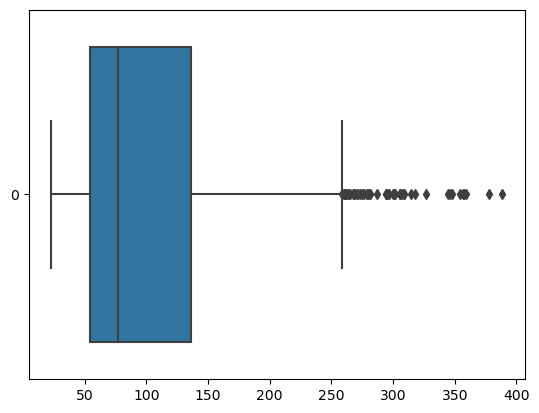

In [15]:
import seaborn as sns

ax = sns.boxplot(data=df['LTC'], orient="h")

Let's estimate the frequency distribution of LTC closing prices. 

**Observations**
- it shows the number of hours LTC had a certain value. For example, we can observe that LTC closing price was not over \$100 for many hours.
- it has right-skewed distribution because a natural limit prevents outcomes on one side.
- blue dotted line (median) shows that half of the closing prices were under 63.50\$.

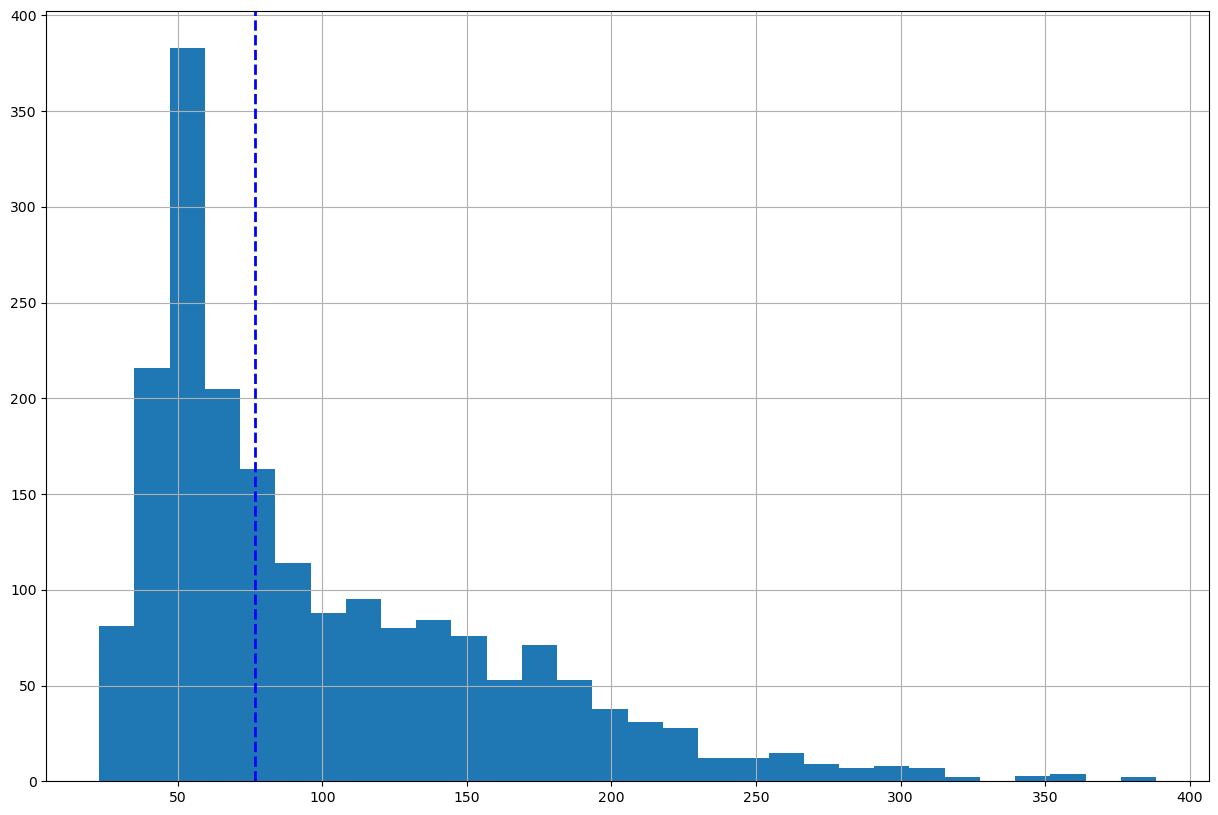

In [16]:
df['LTC'].hist(bins=30, figsize=(15,10)).axvline(df['LTC'].median(), color='b', linestyle='dashed', linewidth=2)

### Visualize absolute closing prices

<AxesSubplot:xlabel='datetime'>

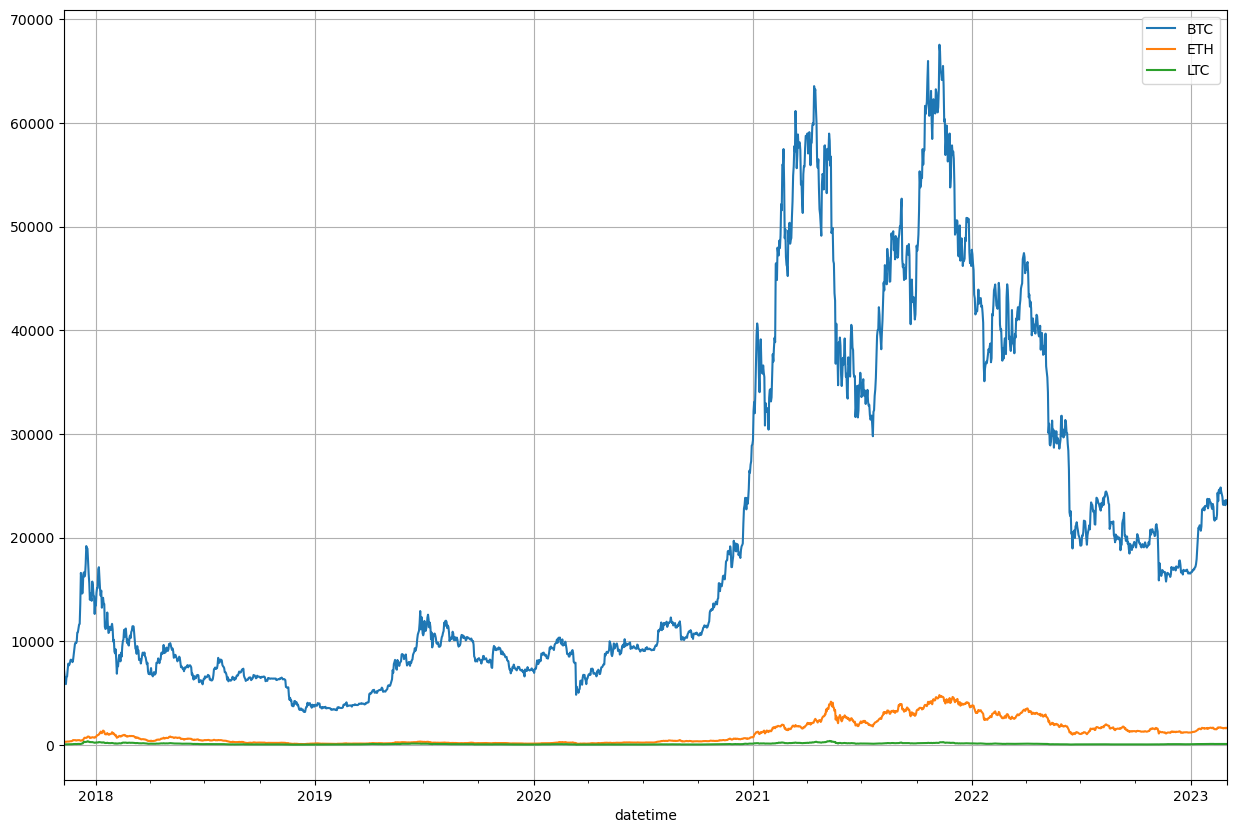

In [17]:
df.plot(grid=True, figsize=(15, 10))

### Visualize relative changes of closing prices

We are interested in a relative change of the price 
rather than in absolute price, so we use three different scales.

We see that closing prices move in tandem. When one coin closing price increases so do the other.

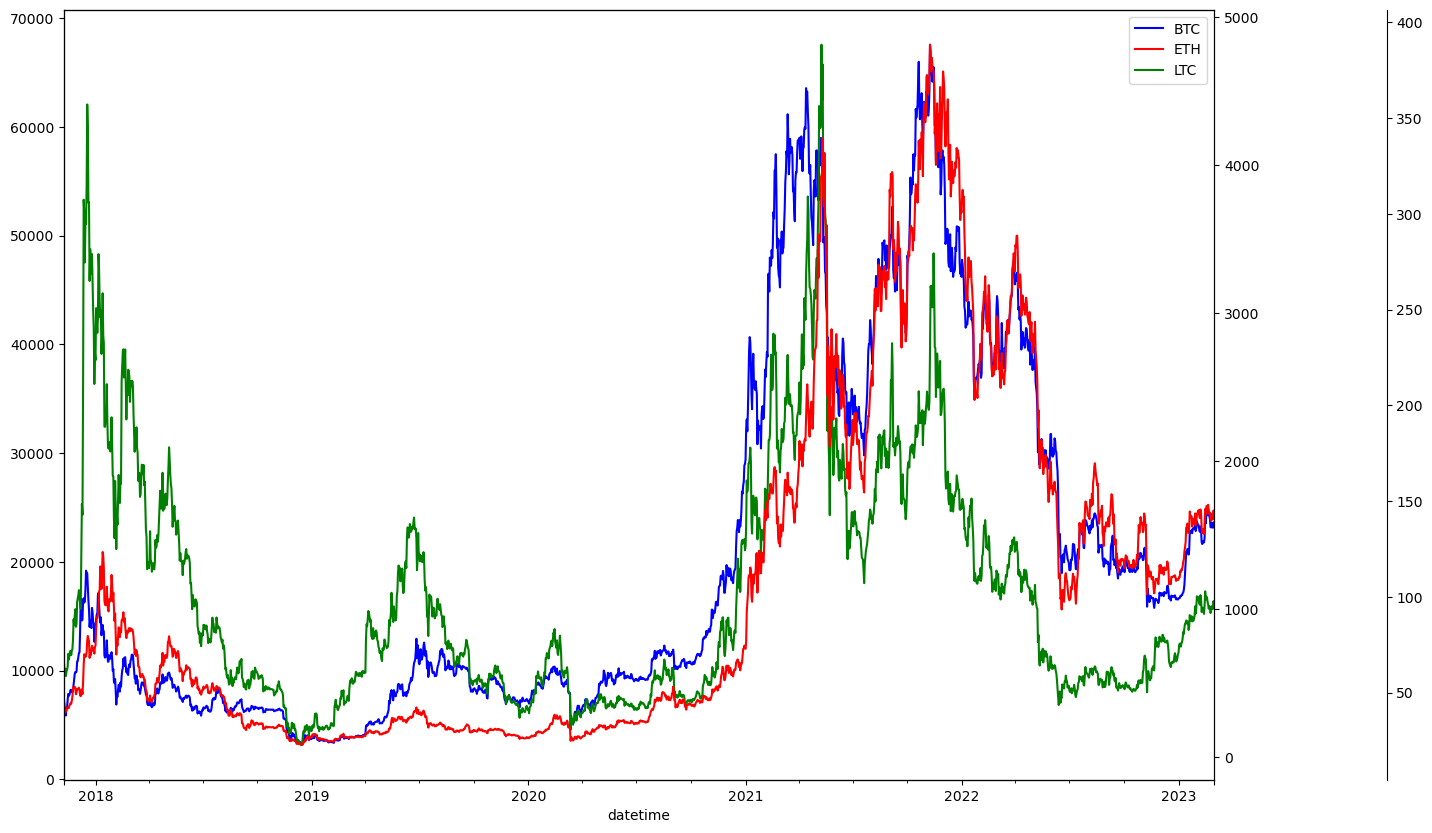

In [18]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()
rspine = ax2.spines['right']
rspine.set_position(('axes', 1.15))
ax2.set_frame_on(True)
ax2.patch.set_visible(False)
fig.subplots_adjust(right=0.7)

df['BTC'].plot(ax=ax1, style='b-')
df['ETH'].plot(ax=ax1, style='r-', secondary_y=True)
df['LTC'].plot(ax=ax2, style='g-')

# legend
ax2.legend([ax1.get_lines()[0],
            ax1.right_ax.get_lines()[0],
            ax2.get_lines()[0]],
           ['BTC', 'ETH', 'LTC'])

### Measure correlation of closing prices 

We calculate [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)
between closing prices of BTC, ETH and LTC. 
Pearson correlation is a measure of the linear correlation between two variables X and Y. 
It has a value between +1 and −1, where 1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation.

[Sifr Data](https://www.sifrdata.com/cryptocurrency-correlation-matrix/) daily updates Pearson correlations for many cryptocurrencies.

**Observations**
- Corelation matrix is symetric so we only show the lower half. 
- BTC, ETH and LTC were highly correlated in past 2 months. This means, when BTC closing price increased, ETH and LTC followed. 
- ETH and LTC were even more correlated with 0.9565 Pearson correlation coefficient.

C:\Users\abhis\AppData\Local\Temp\ipykernel_19520\4109167805.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

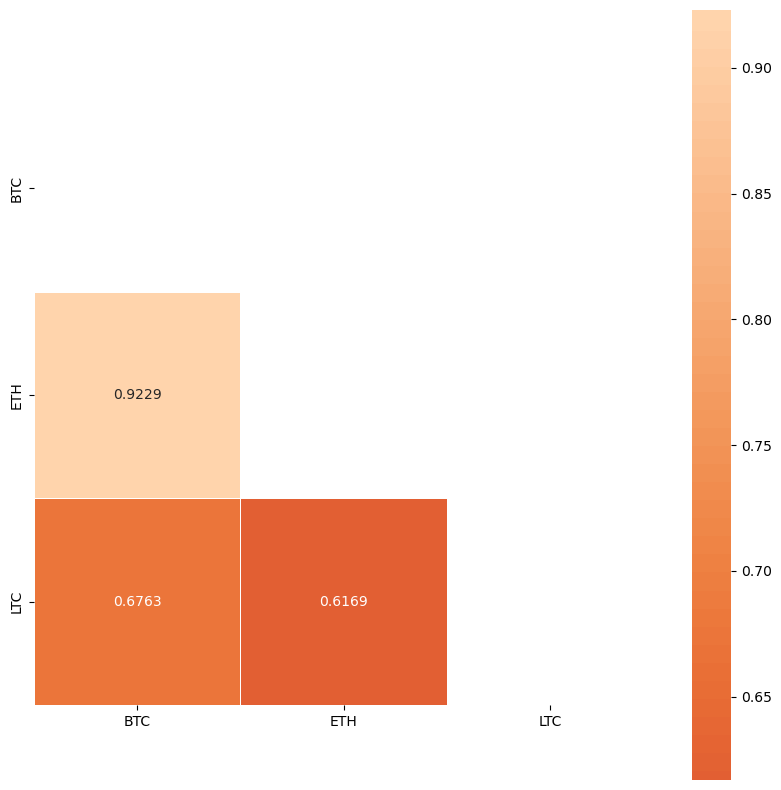

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt = '.4f', mask=mask, center=0, square=True, linewidths=.5)

## Buy and hold strategy

[Buy and hold](https://www.investopedia.com/terms/b/buyandhold.asp) is a passive investment strategy in which an investor buys a cryptocurrency and holds it for a long period of time, regardless of fluctuations in the market. 

Let's analyze returns using buy and hold strategy for past 2.7 months. 
We calculate the return percentage, where $t$ represents a certain time period and $price_0$ is initial closing price:

$$
return_{t, 0} = \frac{price_t}{price_0}
$$

In [20]:
df_return = df.apply(lambda x: x / x[0])
df_return.head()

,BTC,ETH,LTC
datetime,,,
2017-11-09,1.000000,1.000000,1.000000
2017-11-10,0.921682,0.929478,0.916253
2017-11-11,0.889078,0.982696,0.968828
2017-11-12,0.821260,0.952633,0.910360
2017-11-13,0.912867,0.983879,0.946495


### Visualize returns

We show that LTC was the most profitable for time period between October 2, 2017 and December 24, 2017.

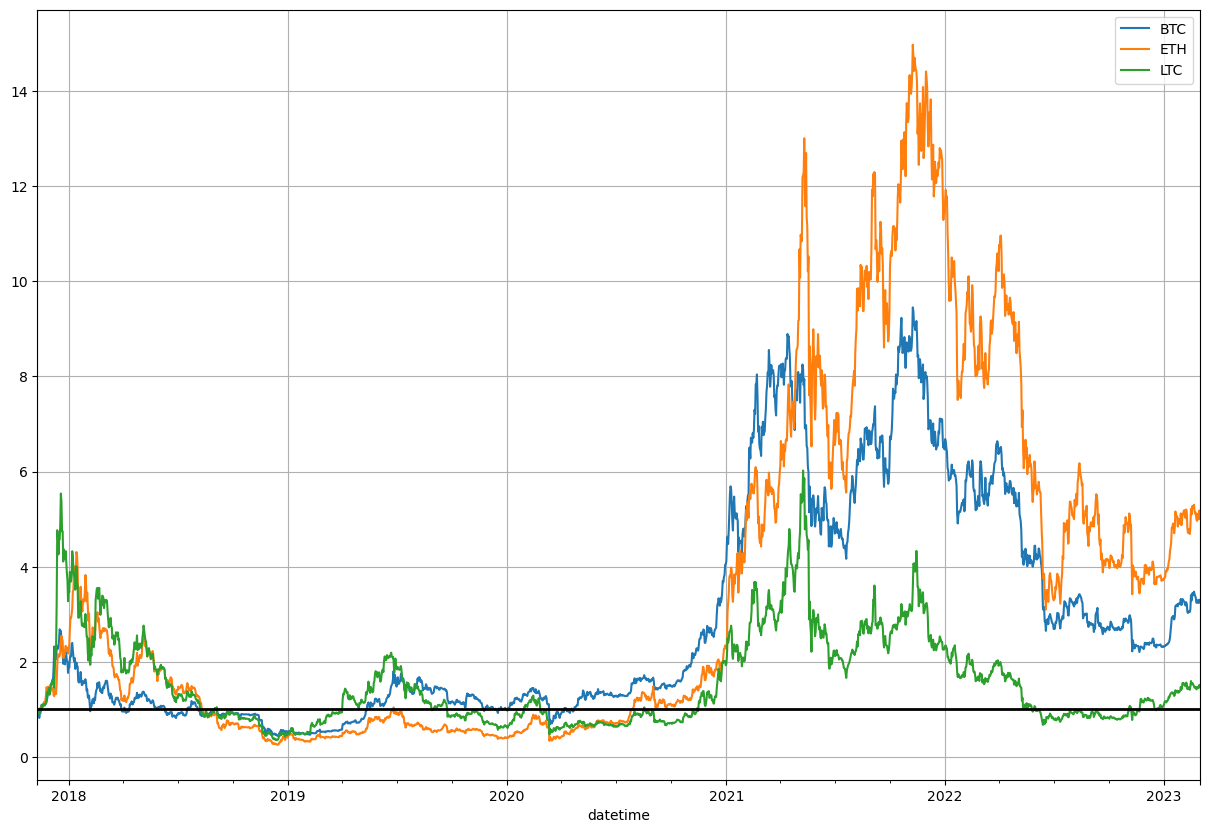

In [21]:
df_return.plot(grid=True, figsize=(15, 10)).axhline(y = 1, color = "black", lw = 2)

## Conclusion

The cryptocurrencies we analyzed fluctuated a lot but all of gained in given 2.7 months period.

### What is the percentage increase?

,BTC,ETH,LTC
datetime,,,
2023-03-02,326.636821,508.309473,148.449132


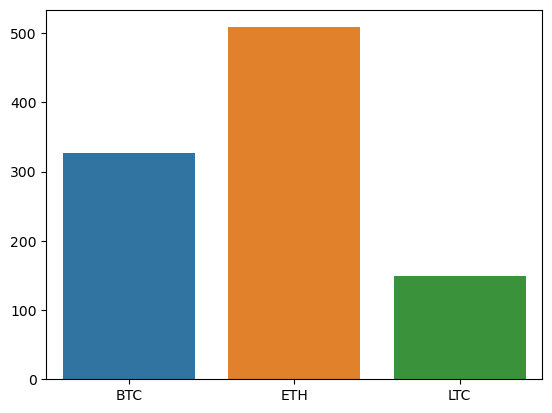

In [22]:
df_perc = df_return.tail(1) * 100
ax = sns.barplot(data=df_perc)
df_perc

### How many coins could we bought for $1000?

,BTC,ETH,LTC
datetime,,,
2017-11-09,0.139899,3.112162,15.508685


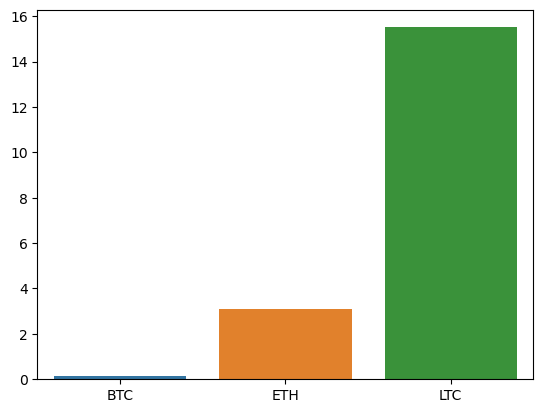

In [23]:
budget = 1000 # USD
df_coins = budget/df.head(1)

ax = sns.barplot(data=df_coins)
df_coins

### How much money would we make?

,BTC,ETH,LTC
datetime,,,
2023-03-02,3266.368215,5083.094734,1484.491315


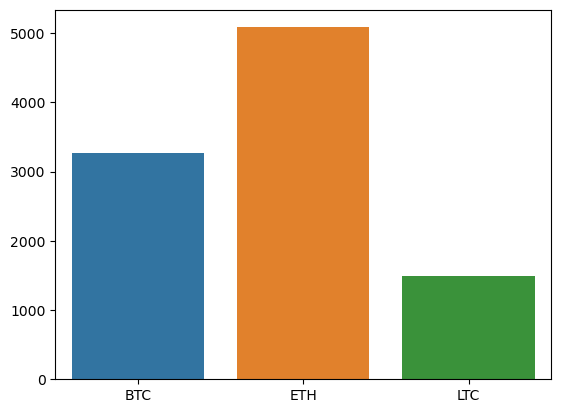

In [24]:
df_profit = df_return.tail(1) * budget

ax = sns.barplot(data=df_profit)
df_profit